In [285]:
using NeuralPDE, Lux, Optimization, OptimizationOptimJL
import ModelingToolkit: Interval

@parameters t, x
@variables u(..)
Dxx = Differential(x)^2
Dtt = Differential(t)^2
Dt = Differential(t)

#2D PDE
C=1
eq  = Dtt(u(t,x)) ~ C^2*Dxx(u(t,x))

u₀(x) = exp(-(x - 1/2)^2/(2*0.04^2))

# Initial and boundary conditions
bcs = [u(t,0) ~ 0.,# for all t > 0
       u(t,1) ~ 0.,# for all t > 0
       u(0,x) ~ u₀(x), #for all 0 < x < 1
    #    Dt(u(0,x)) ~ 0. 
       ] #for all  0 < x < 1]

# Space and time domains
domains = [t ∈ Interval(0.0,1.0),
           x ∈ Interval(0.0,1.0)]
# Discretization
dx = 0.005;
dt = 0.005;

# Neural network
chain = Lux.Chain(Dense(2,16,Lux.σ),Dense(16,16,Lux.σ),Dense(16,1))
discretization = PhysicsInformedNN(chain, GridTraining([dx,dt]),adaptive_loss = NonAdaptiveLoss(pde_loss_weights=1.0,bc_loss_weights=7))

@named pde_system = PDESystem(eq,bcs,domains,[t,x],[u(t,x)])
prob = discretize(pde_system,discretization)

callback = function (p,l)
    println("Current loss is: $l")
    return false
end

#627 (generic function with 1 method)

In [304]:
# optimizer
opt = OptimizationOptimJL.BFGS()
res = Optimization.solve(prob,opt; callback = callback, maxiters=1500)
phi = discretization.phi

Current loss is: 14.741020524012379
Current loss is: 8.932511153917515
Current loss is: 1.5465119655109714
Current loss is: 1.1397761144784468
Current loss is: 0.6832310004731991
Current loss is: 0.6075596032174051
Current loss is: 0.5196882085999224
Current loss is: 0.49115330923058065
Current loss is: 0.47408945228109955
Current loss is: 0.466758512485835
Current loss is: 0.44913953460076506
Current loss is: 0.44789299933747817
Current loss is: 0.4476820943027938
Current loss is: 0.44756818345512606
Current loss is: 0.4475551178682433
Current loss is: 0.44726443306326713
Current loss is: 0.44718574157457425
Current loss is: 0.44712217415942196
Current loss is: 0.44703194358906273
Current loss is: 0.44692422277371513
Current loss is: 0.4466335582254575
Current loss is: 0.44662184390946646
Current loss is: 0.44662084744538544
Current loss is: 0.44660994677692495
Current loss is: 0.44658304864210907
Current loss is: 0.44656535982744766
Current loss is: 0.4465418647002936
Current loss is

NeuralPDE.Phi{Chain{NamedTuple{(:layer_1, :layer_2, :layer_3), Tuple{Dense{true, typeof(NNlib.sigmoid_fast), typeof(Lux.glorot_uniform), typeof(Lux.zeros32)}, Dense{true, typeof(NNlib.sigmoid_fast), typeof(Lux.glorot_uniform), typeof(Lux.zeros32)}, Dense{true, typeof(identity), typeof(Lux.glorot_uniform), typeof(Lux.zeros32)}}}}, NamedTuple{(:layer_1, :layer_2, :layer_3), Tuple{NamedTuple{(), Tuple{}}, NamedTuple{(), Tuple{}}, NamedTuple{(), Tuple{}}}}}(Chain(), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [312]:
res2 = res

u: ComponentVector{Float64}(layer_1 = (weight = [-54.67521981616128 54.675231783649856; 8.442129722631904 4.3910780607895115; … ; -15.711345877235415 -40.933265895710775; 69.98727018284974 -69.98739151220192], bias = [-29.060315009823803; 12.525012997547792; … ; -21.479003678983712; 29.908621349237908;;]), layer_2 = (weight = [0.9041152019477645 1.841885912279395 … 1.6138857794029926 1.159478626010203; 8.57304532912007 -3.7483385004911884 … 0.9730612253317882 -2.158383445348377; … ; 3.821747806647055 -6.307228931790996 … -3.4538073535271336 2.079621092149563; 0.10006007567881778 -8.319430177405858 … -6.3636395793470095 -0.6786408716694651], bias = [1.8358176653002307; 3.67325649057078; … ; -2.676862210992683; 6.37118301576379;;]), layer_3 = (weight = [1.4442184029855312 2.6726541673199084e-6 … -12.944702384326174 -0.04653858691918854], bias = [3.4815911430260322;;]))

In [314]:
# using JLD2
# res = jldopen("wave_eq_sol-X-bcs.jld2")
# res = jldopen("wave_eq_sol-nice.jld2")

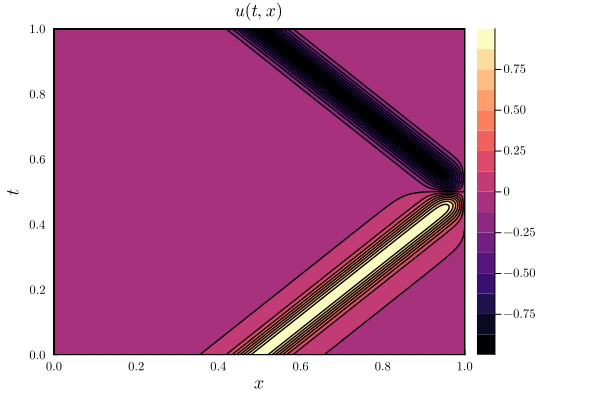

In [310]:
using Plots, PlotThemes, LaTeXStrings; theme(:dao)

ts,xs = [infimum(d.domain):dx:supremum(d.domain) for d in domains]
# analytic_sol_func(t,x) =  sum([(8/(k^3*pi^3)) * sin(k*pi*x)*cos(C*k*pi*t) for k in 1:2:50000])

u_predict = reshape([first(phi([t,x],res.u)) for x in xs for t in ts],(length(ts),length(xs)))
# u_real = reshape([analytic_sol_func(t,x) for t in ts for x in xs], (length(ts),length(xs)))
plot(xs,ts, u_predict, linetype=:contourf,title = L"u(t,x)",xlabel=L"x",ylabel=L"t")
# savefig("wave-no-bcs-cont.pdf")

In [289]:
using ColorSchemes

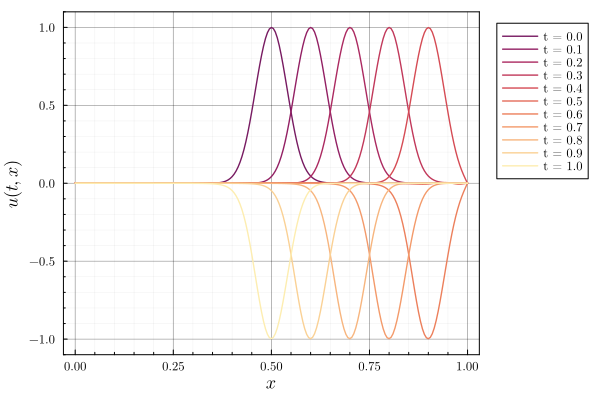

In [311]:
plot()
for t in 0:0.1:1
    plot!(xs,[first(phi([t,x],res.u)) for x in xs],ylim=(-1.1,1.1),label="t = $t",linecolor=ColorSchemes.matter[201-(Int∘floor)(200*t)])
end
plot!(xlabel=L"x",ylabel=L"u(t,x)")
# savefig("wave-no-bcs-per-x.pdf")


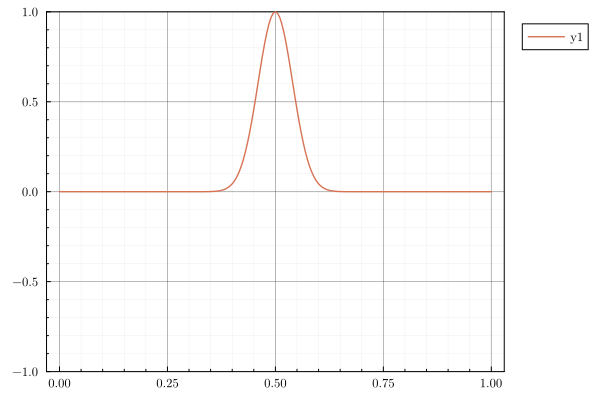

In [291]:
plot(xs,[u₀(x) for x in xs],ylim=(-1.0,1.0))
